In [253]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# 开始计时
start_time = time.time()


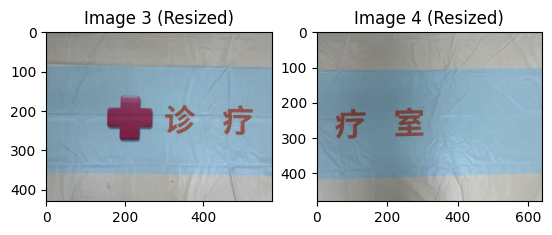

In [254]:
# 加载图像并缩小尺寸
img1 = cv2.imread('8.jpg')
img2 = cv2.imread('9.jpg')

# 缩小图像尺寸（可根据需要调整比例）
scale_factor = 0.5  # 图像缩小的比例
img1 = cv2.resize(img1, (0, 0), fx=scale_factor, fy=scale_factor)
img2 = cv2.resize(img2, (0, 0), fx=scale_factor, fy=scale_factor)

# 显示缩小后的图像
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)), plt.title('Image 3 (Resized)')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)), plt.title('Image 4 (Resized)')
plt.show()


图像 3.jpg 的特征点数量: 164
图像 4.jpg 的特征点数量: 112


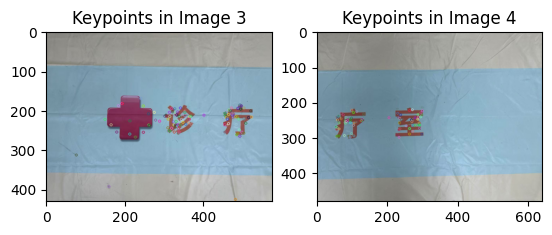

In [255]:
# 创建 SIFT 检测器，限制最大特征点数目为500
sift = cv2.SIFT_create(nfeatures=500)

# 检测特征点并计算描述符
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# 输出特征点的数量
print(f"图像 3.jpg 的特征点数量: {len(kp1)}")
print(f"图像 4.jpg 的特征点数量: {len(kp2)}")

# 绘制特征点
img_kp1 = cv2.drawKeypoints(img1, kp1, None)
img_kp2 = cv2.drawKeypoints(img2, kp2, None)

# 显示特征点
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(img_kp1, cv2.COLOR_BGR2RGB)), plt.title('Keypoints in Image 3')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(img_kp2, cv2.COLOR_BGR2RGB)), plt.title('Keypoints in Image 4')
plt.show()


筛选后的良好匹配数量: 21


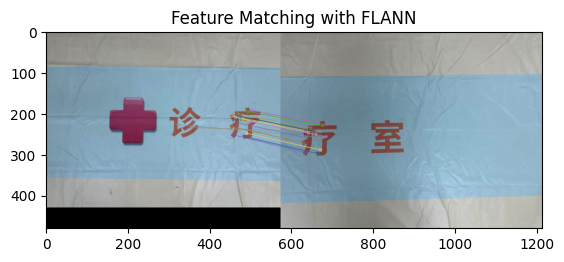

In [256]:
# FLANN参数设置
FLANN_INDEX_KDTREE = 1  # 使用 KDTree 作为搜索算法
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)  # trees 是搜索的树数目
search_params = dict(checks=50)  # 传递检查数，通常越高越精确但慢

# 创建 FLANN 匹配器
flann = cv2.FlannBasedMatcher(index_params, search_params)

# 使用 knnMatch 进行匹配，k=2 表示选择两个最好的匹配项
matches = flann.knnMatch(des1, des2, k=2)

# 根据 Lowe's ratio test 筛选匹配，保留最好的匹配
good_matches = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:  # 比较最好的匹配与次好的匹配，保留最好的
        good_matches.append(m)

# 输出筛选后的匹配数量
print(f"筛选后的良好匹配数量: {len(good_matches)}")

# 绘制匹配结果
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# 显示匹配结果
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title('Feature Matching with FLANN')
plt.show()


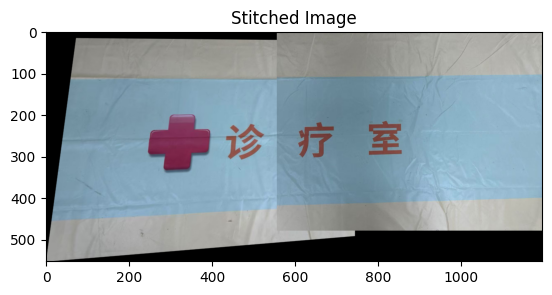

拼接完成


In [257]:
if len(good_matches) > 10:
    # 提取匹配的关键点位置
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    # 计算单应性矩阵
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 6.0)

    # 获取两张图像的尺寸
    height1, width1, _ = img1.shape
    height2, width2, _ = img2.shape

    # 获取第一张图像透视变换后可能的四个角的位置
    corners_img1 = np.float32([[0, 0], [width1 - 1, 0], [width1 - 1, height1 - 1], [0, height1 - 1]]).reshape(-1, 1, 2)
    transformed_corners_img1 = cv2.perspectiveTransform(corners_img1, H)

    # 获取第二张图像的四个角的位置
    corners_img2 = np.float32([[0, 0], [width2 - 1, 0], [width2 - 1, height2 - 1], [0, height2 - 1]]).reshape(-1, 1, 2)

    # 将 transformed_corners_img1 和 corners_img2 从三维数组转换为二维数组
    transformed_corners_img1 = transformed_corners_img1.reshape(-1, 2)
    corners_img2 = corners_img2.reshape(-1, 2)

    # 计算合并图像的最小矩形区域
    all_corners = np.concatenate((transformed_corners_img1, corners_img2), axis=0)
    [x_min, y_min] = np.int32(all_corners.min(axis=0).flatten() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).flatten() + 0.5)

    # 平移变换矩阵
    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    # 进行透视变换并拼接图像
    result = cv2.warpPerspective(img1, H_translation.dot(H), (x_max - x_min, y_max - y_min))

    # 确保拼接区域的大小一致
    result_height, result_width, _ = result.shape
    if result_height < translation_dist[1] + height2:
        result = cv2.copyMakeBorder(result, 0, translation_dist[1] + height2 - result_height, 0, 0, cv2.BORDER_CONSTANT)
    if result_width < translation_dist[0] + width2:
        result = cv2.copyMakeBorder(result, 0, 0, 0, translation_dist[0] + width2 - result_width, cv2.BORDER_CONSTANT)

    # 将 img2 放置在 result 的左上角
    result[translation_dist[1]:translation_dist[1] + height2, translation_dist[0]:translation_dist[0] + width2] = img2

    # 显示拼接结果
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Stitched Image')
    plt.show()

    # 输出拼接完成
    print("拼接完成")
else:
    print("匹配点不足，无法进行拼接")


In [258]:
# 结束计时
end_time = time.time()

# 计算处理时间和帧率
total_time = end_time - start_time
frame_rate = 1 / total_time  # 假设只处理了一帧图像
print(f"处理时间: {total_time:.4f} 秒")
print(f"帧率: {frame_rate:.2f} FPS")


处理时间: 0.9679 秒
帧率: 1.03 FPS
